# Multiple particles falling in the F-layer

This notebook outlines how we can use our model of a single falling and growing iron particle 
to create a self consistent solution to propoerties of the F-layer and an estimate of the inner
core growth rate. We assume at the outset that we can track the growth and position of a single
falling iron particle with time. This is set up as a pair of coupled ODEs and solved as an IVP. 
This is implemented inside the `boundary_layer` model making use of the SciPy `integrate.solve_ivp`
interface to an explicit 5th order Runga-Kutta solver. We make extensive use of event tracking and
interpolated solutions given by this implementation.

The aim is to (1) look at how the results of our method varies with input parameters and (2)
compare our non-equilibrium approach to a simple equilibrium model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize as spo
import scipy.interpolate as spi
import particle_evolution
import feo_thermodynamics as feot

Pr =  0.09075  Sc =  999.9999999999999


In [2]:
# We will use PREM for pressure, gravity etc.
import sys
sys.path.append('/Users/andrewwalker/Code/prem4derg') # This is rubbish. Make it pip-installable? 
import earth_model
prem = earth_model.Prem()

## F-layer setup

We need a reasonable description of the F-layer. We do this by defining a radius for the ICB 
and a radius for the top of the F-layer, assume that pressure (and gravity) are given by PREM,
and define functions for temperature and composition. (The following function generates the functions
we'll need). 

The (total) composition is assumed to be constant in the core above the F-layer, and may vary as a linear 
function of radius within the F-layer. This is set up by providing two compositions, one
at the top and one at the bottom of the F-layer. These are provided as mole fraction Fe
and are needed to set up the temperature.

For temperature we extrapolate down an adiabat until we reach the top of the F-layer and then
assume a linear variation in temperature with radius. The adiabatic temperature is given by:

$$ T_a(r) = T_{CMB} \left(\frac{\rho(r)}{\rho_{CMB}}\right)^{\gamma} $$

where $\gamma$ is the Grunissen parameter for the core (e.g. 1.5) and $T_{CMB}$ is the 
temperature at the CMB. We $\gamma$, assume PREM for the density, and find $T_{CMB}$ such
that $T_a(r)$ is equal to the liquidus (at our chosen composition) at the top of the F-layer.
This is done by root finding. 
We choose the temperature at the ICB by further extrapolating down the adiabat and applying 
a small change (or order 10 K) such that the F-layer can be sub- (or super-) adiabatic.

Note that allowing the temperature and composition to vary with radius could allow the
F-layer to depart from the two phase region (either by dipping below the solidus/eutectic
temperature or by exceeding the pressure-dependent liquidus). Do check.

In [3]:
def setup_flayer_functions(r_icb, r_cmb, r_flayer_top, gamma, delta_t_icb, xfe_adiabatic, xfe_icb):
    """
    This defines the radial functions we are going to need to model the f-layer
    
    Our input parameters are the (total) oxygen content at the top and bottom of 
    the layer, the subadiabatic cooling through the layer, a value for gamma
    for the adiabatic mantle and a thickness of the layer. We first uuse this 
    to find the liquidus temperature at the top of the F-layer. We then requier
    the CMB temperature to generate an adiabat that intersects the liquidus at the
    top of the f-layer.
    
    Arguments are:
    
    r_icb: ICB radius in m
    r_cmb: core mantle boundary radius in m
    r_flayer_top: radius of the top of the f-layer in m
    gamma: grunisen parameter for adiabatic core, dimensionless (1.5 is a typical value)
    delta_t_icb: subadiabatic temperature depression at the ICB in K, 10 K is a sensible value
    xfe_adiabatic: oxygen content (as mol frac Fe) of the adiabatic core (and top of the F-layer)
                    8-17 mol % O (i.e. 0.92-0.83) are sensible values
    xfe_icb: oxygen content (as mol frac Fe) at the bottom of the F-layer. NB: this is the total oxygen 
             content. As O partititons into the liquid the liquid will be enriched. 
    
    We end up returning a functions that can give the total oxygen content as a function
    of radius, the temperature as a function of radius, and the pressure (from PREM) as
    a function of radius. In the F-layer we assume linear temperature and composition
    profiles. These functions are (numpy) vectorized and take the radii in m. 
    """
    # First find the liquidus temperature at the top of the F-layer... we know P (from PREM)
    # and X (from our input). NB: my PREM module works in km and does not like vector input.
    # This is quite slow and could be optimised by avoiding the double brentq calls!
    tl_top_flayer = feot.find_liquidus(xfe_adiabatic, prem.pressure(radius_top_flayer/1000.0))
    print("Liquidus temperature at top of F-layer is", tl_top_flayer, "K")
    
    # Now we need to work out the adiabatic temperature profile that intersects the liquidus 
    # at the top of the F-layer. 
    rho_cmb = prem.density((radius_cmb-0.1)/1000.0) # -0.1 for core, not mantle rho
    rho_top_flayer = prem.density(radius_top_flayer/1000.0)
    def _t_error_top_flayer(tcmb):
        """
        For a given CMB temperature, calculate the difference between the temperature
        at the top of the f-layer and the liquidus temperature. We'll need to set 
        tcmb such that this is zero!
        """
        adabat_t_top_flayer = tcmb * (rho_top_flayer/rho_cmb)**gamma
        t_error = adabat_t_top_flayer - tl_top_flayer
        return t_error
    t_cmb = spo.brentq(_t_error_top_flayer, 1000, 8000)
    
    print("Temperature CMB is", t_cmb, "K")
    
    # We can now build our function to give the adiabatic temperature
    rho_icb = prem.density(radius_inner_core/1000.0)
    adabat_t_top_flayer = t_cmb * (rho_top_flayer/rho_cmb)**gamma
    adabat_icb = t_cmb * (rho_icb/rho_cmb)**gamma
    @np.vectorize
    def adiabatic_temperature_function(r):
        temp = t_cmb * (prem.density(r/1000.0)/rho_cmb)**gamma
        return temp
    
    # And the function to give the 'real' temperature (including a subadiabatic layer)
    # We'll base temperature on an adiabat (temperature at top of F-layer)
    # and then assume it's linear to a subadiabatic ICB temperature
    # Do note that we cannot use the ICB as a tie point as (1) the F-layer
    # is not adiabatic and (2) we are not assuming phase equilibrium at the ICB
    # which means the ICB need not be at any particular melting temperature. 
    # This is an important point (probably the most important point if we introduce
    # non-equilibrium processes).
    temperature_icb = adabat_icb - delta_t_icb
    @np.vectorize
    def temperature_function(r):
        if r > radius_top_flayer:
            temp = t_cmb * (prem.density(r/1000.0)/rho_cmb)**gamma
        else: # Will give value inside inner core, but we may need that for IVP solver...
            temp = temperature_icb + (r - r_icb)*(
                (adabat_t_top_flayer-temperature_icb)/(r_flayer_top-r_icb))
        return temp
    

    # Finally, a function to give the composition everywhere
    @np.vectorize
    def composition_function(r):
        if r > radius_top_flayer:
            xfe = xfe_adiabatic
        else:
            xfe = xfe_icb + (r - r_icb)*(
                (xfe_adiabatic-xfe_icb)/(r_flayer_top-r_icb))
        return xfe
    
    @np.vectorize           
    def pressure_function(r):
        return prem.pressure(r/1000.0)
    
    @np.vectorize
    def gravity_function(r):
        return prem.gravity(r/1000.0)
    
    return temperature_function, adiabatic_temperature_function, composition_function, \
        pressure_function, gravity_function


Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


/Users/andrewwalker/miniforge3/envs/py38-arm/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


Liquidus temperature at top of F-layer is 5498.208659148993 K
Temperature CMB is 4093.1090713644544 K


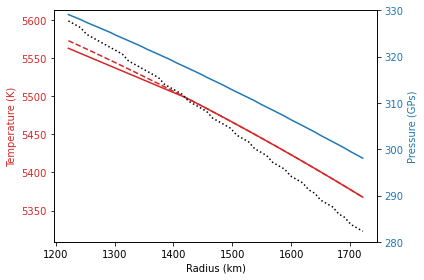

In [4]:
# This is where we set all the F-layer parameters. Quite slow (due to liquidus calc I think)

# F-layer setup
radius_inner_core = 1221.5e3
radius_top_flayer = radius_inner_core + 200.0e3 # 200 km thick.
radius_cmb = 3480.0e3 # We only need this for setup.
gamma = 1.5

# Check PREM works
print("Pressure at ICB:", prem.pressure(radius_inner_core/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(radius_top_flayer/1000.0), "GPa")
print("g at ICB:", prem.gravity(radius_inner_core/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(radius_top_flayer/1000.0), "m/s**2")

# Generate the functions for temperautre,
# composition, pressure and gravity
tfunc, atfunc, xfunc, pfunc, \
    gfunc = setup_flayer_functions(radius_inner_core, radius_cmb, radius_top_flayer, 
                                                    gamma, 10.0, 0.92, 0.92)

# Interpolate onto radius for plotting
rs = np.linspace(radius_inner_core, radius_inner_core+500.0E3)
ts = tfunc(rs)
ats = atfunc(rs)
ps = pfunc(rs)
xs = xfunc(rs)
# Find the P-X dependent liquidus (storing the temperature at each point)
tl = feot.find_liquidus(xs, ps)


# Plot the F-layer setup alongside the liquidus
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ts, color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, ps, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([280, 330])

fig.tight_layout()  
plt.show()

## Equilibrium calculation

We've covered all of this before elsewhere. The only innovation is to 
allow pressure and composition to vary with temperature.

/Users/andrewwalker/miniforge3/envs/py38-arm/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)
/Users/andrewwalker/miniforge3/envs/py38-arm/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


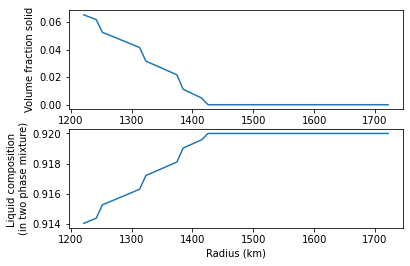

In [5]:
equilib_vol_frac = feot.volume_fraction_solid(xs, ps, ts) # Why do these give steppy answers?
x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, ps, ts)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(rs/1000.0, equilib_vol_frac)
ax[0].set_ylabel('Volume fraction solid')
ax[0].set_xlabel('Radius (km)')
ax[1].plot(rs/1000.0, x_lq)
ax[1].set_ylabel('Liquid composition \n(in two phase mixture)')
ax[1].set_xlabel('Radius (km)')
plt.show()

**To Do:** 
1. work out why we have the steps in the melting curve and the phase relations output. Looks like
some numerical convergence thing but I would expect that to be more random.
2. Think about falling time and crstal size in the equilibrium case. 
3. Think about physical propertiese (layer density structure, bulk modulii, P-wave velocity

**TODO: check and integrate Chris comments. Do we care about the spacing any more?

## Non-equilibrium calculation

For the overall non-equilibrium calculation we make use of the previously implemented
code to track the growth and falling velocity of an isolated crystal. The innovation
is in bringing these together into a model of the F-layer. Setup of the F-layer is
described above.

### The particle density and optimisation of theliquid composition

Thus far we have treated the liquid composition around the falling particles as an
externally imposed parameter. However, we would like the composition (in terms of 
total oxygen content) of the F-layer to be conserved. As crystals grow oxygen
is enriched in the residual liquid (because it is excluded from the solid). What
we do is run a set of calculations with the liquid oxygen content set equal to the
imposed total oxygen content. Calculate the volume of solid in the F-layer from this
calculation and use this to recalculate the liquid composition (assuming that the
boundary layers play an insignificant role in the overall composition, and that the
total oxygen in the F-layer is conserved). This gives a new total oxygen content in
the layer. We then use this as the imposed oxygen content for the particle evolution
equation and iterate. We hope this converges (**question: can we argue that it must on
the basis of the growth rate being related to the oxygen content of the liquid?**)

In fact, we want the F-layer to be able to generate a gradient in oxygen content
and solid volume fraction. We'll thus set up a serise of layers and conserve
oxygen content in eacg layer. **Question: what sort of non-equilibroum will this
permit? The bulk liquid composition will not be the composition that is in
equilibrioum with the solid due to the boundary layer. This means that (once convereged)
we will not be in phase equilibrium either. However, we will conserve mass. 
I think this measn we say something like "we allow departures from phase equilibrium
and only impose chemical equilibrium in a limited way (no gradients in bulk solid or
bulk liquid).** 

In order to set this up we need to self consistently
solve the falling particles ODEs using the following algorithem:

1. Set an initial guess for the liquid composition (equal to the total composition)
2. Solve ODEs 
3. Calculate liquid composition in each layer such that the total coposition is conserved
4. If these do no match repeate from 2 otherwise
5. Evaluate crystal size distribution and inner core growth rate.

Note that for many falling particles nucleating throughout the liquid composition will
need to change through the layer (we may expect it will be more oxygen rich downwards as the 
number density of particles and their sizes increases downwards). 

Given the above, we need a way to evaluate the number density and total volume of particles at any
depth in the F-layer. The information we have is the nuclation rate, $\mathscr{N}(r_n)$, 
and relationship between the particle position $r_p(r_n, t)$ with time, $t$. Both are functions
of the nuclation position $r_n$. We also have access to the particle radius, $R(r_n, t)$. 

We start by calculating the 'partial number density', number of particles per cubic meter that
at position $r$ that nucleated at $r_n$. For this we need the spacing between particles nuclating
in a given volume around $r_n$, which we call $V_n$. From the definition of $\mathscr{N}$ we
know that the mean waiting time between nucleation events is:

$$\tau = \frac{1}{2 \mathscr{N}(r_n) V_n}$$

and the mean position of nucleation will be at the center of the volume represented by $V_n$.
The factor of a $\frac{1}{2}$ arised because half of the nuclii that reach the critical radius
then dissolve (some definitions of $\mathscr{N}$ will not include this). $\tau$ should be in
units of time.

Particles falling from any given location will follow identicle trajectories whatever time they
start (because we are assuming the F-layer is in steady state). That is, if $r_p(r_n, t)$ and
$R(r_n, t)$ are solutions to the IVP for a particle nucleating at $t_0$, solutions for an IVP
where the particle nucleated at $t_0 + \tau$ will be $r_p(r_n, t + \tau)$ and $R(r_n, t + \tau)$
and we have solutions available whatever the nucleation time. At some $r$ we can thus calculate
the vertical distance, $s_z$ between particles by taking the difference in $r_p$ for particles
nucleating $\tau$ before and after $t_0$:

$$s_z = \frac{\left(r_p(r_n, t) - r_p(r_n, t + \tau)\right) + \left(r_p(r_n, t - \tau) + r_p(r_n, t)\right)}{2}$$

And the vertical partial particle density is $\rho_p(r_n) = \frac{1}{s_z}$. The seperation between paticles in
the horizontal direction is determined by the cross sectional area of the nucleation volume 
(the particles just sink downwards). On average this will be the distance between the centers of
the nucleation volumes. If we arrange for the cross-sectional area to be 1 m$^2$ the vertical 
parital particle density will be the partial particle density (in particles per m$^3$). We can
either envisage these particles to nucleate and fall in 'sheets' or imagine a stocastic process
(in which case the positions are the mean positions and the density is a mean density. This
analysis ignores the change in shell area with radius. **Note: do we need to account for change in
cross sectional area with r in spherical geometry?**



We now need to consider the paricles that nucleate at other depths. These will have different solutions
to the IVP, and thus different seperations and densities. The total (number) density of particles
at some depth $\rho(r)$, is just the sum of the partial densities from all nucleation depths above the height of
interest. We can evaluate this as an integral over nucleation depths:

$$\rho(r) = \int_{r}^{r_{top}} \rho_p(r_n) \mathrm{d}r_n $$

where $r_{top}$ is the top of the F-layer.

So we need to calculate $\rho(r)$ at some set of radii, convert this into a particle seperation, express the 
seperation as a contiuous function, and feed this back in as the radius of the interaction volume in the IVPs.
The iteraction radius (particle seperation) is given by the Wigner–Seitz radius:

$$r_{sep}(r) = \left(\frac{3}{4\pi\rho(r)}\right)^{\frac{1}{3}} $$

### Inner core growth

Once we have a self-consistent solution, it is quite easy to evaluate the solid
volume fraction at any radius, and the inner core growth rate. 

The inner core growth rate (by sedimentation), $G_{ic}$, is given by the volume of solid reaching the
ICB per unit time. This is found by integrating the volume of particles that formed everywhere in the 
F-layer according to their nuclation radius and deviding by the area of the ICB:

$$G_{ic} = \frac{1}{ 4 \pi r_{icb}^2}\int_{r_{icb}}^{r_{top}} 4 \pi r_n^2 . \frac{4}{3}\pi R(r_n, t_{icb})^3 . \frac{ \mathscr{N}(r_n)}{2} \mathrm{d}r_n$$

The term outside the integral is the area of the ICB. The first term inside the intergral accounts for the 
spherical shell geometry, the second is the volume of the particles as they reach the ICB having nucleated
at $r_n$, and the third term gives the number of these particles. The integral is over nucleation position.

**To do:** do we actually implement the factor of a half in the nucleation rate?


### Solid volume fraction

The volume fraction solid, $V_f(r)$ at any radius can be evaluated in a similar way as the total volume of solid
(per unit volume) is the product of the particle number density and the radii:

$$V_f(r) = \int_{r}^{r_{top}} \rho_p(r_n) \frac{4}{3}\pi R(r_n, t_r)^3 \mathrm{d}r_n $$

**To do:** do we need a geometrical term?

Once we know $V_f(r)$ we can evaluate the liquid composition (and thus density) by conservation of oxygen 
(all the oxygen is in the liquid).

### Implementation

We choose a set of integration depths / nucleation depths ($r_n$) above and use each one as the starting
depth for the IVP solver and for the descrete depths for numerical integration of the integrals above. 
Some brief testing seems to show that O(10) is more than enough points for the case I looked at (but careful
checking may be useful). We also choose a set of radii (just $r$ above) where we want to evaluate $\rho_p$ and 
$V_f$. We provide these to the IVP solver as non terminal 'events' and also check for dissolution of the particle
and for the particle hitting the ICB (these are 'terminal events'). What this means is that we can easily get hold
of the time and particle radius when the solution hit these depths from the IVP solution objects. We run each IVP
and store the solution objects in a list. We also need to apply small changes to the time to work out the 
seperation between particles. We do this by asking the IVP solver to fit an interpolation function to the solution.
We can then use the time (from the event) and apply an offset to find the position the particle was at a short time
before or after the event was triggered. We can use the termination event to find the ICB growth rate. To make this
all work we need to know when event corresponds to which depth. Events are stored (in the IVP solution) in a list.
Event 0 is 'hit the ICB', event 1 is 'dissolved' and subsiquent events correspond to our analysis radii in order.
Note that accessing these events needs us to check that the particle has not dissovled (or never reached) the analysis
radius of interest. Super. Glad that makes sense. It is also useful to know that the events information is stored in
`t_events` (for times) and `y_events` (for radius, in element 0, and position, in element 1). 

This may all make a bit more sense in terms of code. The function in the next cell just dumps out everything we 
know about the events found in a single IVP solution. Last thing to watch - events can (in principle) be triggered
multiple times, so we have to watch for this!

In [6]:
def report_all_solution_events(sol, analysis_depths):
    """
    Print out what happend to a single ODE IVP falling calculation
    
    We are careful to check when things don't happen. And check for 
    double crossings of depths (say we have upward falling) but just
    treat that as an error for now.
    """
    if not sol.t_events[0].size > 0:
        print('did not reach icb')
    else:
        assert sol.t_events[0].size == 1, "Double crossing detected"
        print('icb at t = ', sol.t_events[0][0], 's, with particle radius = ', sol.y_events[0][0][0])
    
    if not sol.t_events[1].size > 0:
        print('did not dissolve')
    else:
        print('particle dissolved at t = ', sol.t_events[1][0], 's')
    for i, r in enumerate(analysis_depths):
        if sol.t_events[i+2].size > 0:
            assert sol.t_events[i+2].size == 1, "Double crossing detected"
            print("reached r = ", r, 'm at t = ', sol.t_events[i+2][0], 's, with particle radius = ', sol.y_events[i+2][0][0])
        else:
            print('did not reach r = ', r, 'm')
    print("")
            


The following cell contains all the code to actually do the 
self consistent soluton. Needs clean up. In particular

**To do:** 

1. don't access the F-layer setup functions from the global scope,
pass them as arguments (global state is bad
2. consider making `run_ivps_for_snow_zone` run the IVPs in parallel
3. reduce prited output (pass in and use a verbose argument everywhere)

In [7]:
# Calculate parile seperation and 'partial' density
def partial_particle_density(ivp_solution, event_index, nucleation_rate, nucleation_volume, verbose=True):
    """
    Evaluate the 'partial' particle density at a given radius given a single solution to the IVP
    

    ivp_solution: solution object for IVP. Must have events attached. Must also have dense 
            output (i.e. a smooth interpolator) attached
    event_index: index into list of events in ivp_solution where analysis is to be perfomed. 
            This must correspond to the particle crossing the depth of interest and a sutible
            'event' must thus be attached to the IVP solution object. The event need not have
            been triggered (e.g. the particles could dissolve before reaching the radius of
            interest). 
    nucleation_rate: the rate of nucleation for the radius corresponding to t=0 for the IVP
            This is where the particles we are forming before they fall through our radius
            of interest (in particles per m^3 per s).
    nucleation_volume: the volume where nucleation takes place (in m^3)
    
    Returns the partial particle density in particles per m^3 nucleating in the volume
    represented by the start of the IVP. This must be integrated to find the total density.
    (See notes in the notebook re. statistical meaning of this given CNT!)
    """
    # Calculate the average time between nucleation events, this is the 'waiting time'
    # of Davies et al. 2019 and includes a factor of 1/2 to account for half of the 
    # particles reaching r_c then dissolving.
    tau = 1.0/(2.0*nucleation_rate*nucleation_volume)
    
    # Find the time where a particle that nucleated at t=0 reached the radius of interest
    # by searching through the IVP events. This cannot be the first (hit ICB) or second
    # (dissolved) event. We need to check even if it did dissolve as that could be below the
    # radius of interest.
    assert event_index > 1, "Cannot processes hit ICB or dissolved data"
    if ivp_solution.t_events[event_index].size > 0:
        assert ivp_solution.t_events[event_index].size == 1, "Double crossing detected"
        # NB: solution y_events indexed by event, then a list of times where the event is
        # seen (we want the first one - index 0) then a list of ys (i.e. particle radius, position)
        # and want the position which is index 1 
        analysis_radius = ivp_solution.y_events[event_index][0][1]
        analysis_time = ivp_solution.t_events[event_index][0]
        # We'll take the distances between this particle (nucleated at t=0) and the
        # one before (nucleated at t = -tau) and the one after (t = tau). Because we 
        # have a steady state solution the whole IVP solution is just shifted in time
        # so we can do the analysis from just this solution and use the dense output
        # to get the distance
        assert ivp_solution.sol(analysis_time)[1] == analysis_radius, "event / interpolator missmatch"
        if (analysis_time - tau) < 0.0:
            print("cannot process if next particle has yet to form")
            return 0.0
        if (analysis_time + tau) > ivp_solution.t[-1]:
            print("cannot process if previous particle has gone")
            return 0.0
        distance_below = analysis_radius - ivp_solution.sol(analysis_time + tau)[1]
        distance_above = ivp_solution.sol(analysis_time - tau)[1] - analysis_radius
        partial_density = 1.0 / (0.5 * (distance_below + distance_above)) # /m^3 - see notebook!
        if verbose:
            print("Partial density calculation at r = ", analysis_radius, "m")
            print("At time t = ", analysis_time, "s, and tau = ", tau, "s")
            print("Previous particle is", distance_below, "m below, next particle is", distance_above, "m above")
            print("Partial particle densituy is", partial_density, "particles / m^3")     
    else:
        # No particles at this depth (above nucleation depth or dissolved)
        # partial density is zero
        partial_density = 0.0
        if verbose:
            print("No event data (e.g. dissolved) so partical density is zero")
        
    return partial_density


# Actually run the IVPs
def run_ivps_for_snow_zone(analysis_depths, integration_depths, nucleation_rates, xl_func):
    # FIXME: other parameters should be arguments
    solutions = []
    for int_depth in integration_depths:
        print("Starting ODE IVP solver for nuclation at", int_depth)
        sol = particle_evolution.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                       int_depth, xl_func, tfunc, pfunc,
                                                       dl, k0, gfunc, mu, radius_inner_core, analysis_depths)
        assert sol.success, "No ODE solution found!"
        report_all_solution_events(sol, analysis_depths)
        solutions.append(sol)
        
    return solutions


# Total particle density and solid volume fraction calculation
def evaluate_partcle_densities(solutions, analysis_depths, integration_depths, nucleation_rates):
    # FIXME: other parameters should be arguments

    print("ODE solved for all nuclation depths... calculating integrals over nuclation depth for particle density")
    particle_densities = np.zeros_like(analysis_depths)
    solid_vf = np.zeros_like(analysis_depths)
    particle_radius_histogram = np.zeros((analysis_depths.size, integration_depths.size))
    particle_radius_unnormalised = np.zeros((analysis_depths.size, integration_depths.size))
    for i, analysis_r in enumerate(analysis_depths):
        analysis_index = i + 2
        # Particle density at this depth is 'just' the partial density
        # (density from nucleation depth) integrated over nuclation depths
        # It's okay to integrate nuc depths below int depth as this will
        # return zero density. This is a 1D integral (see notebook)
        partial_densities = np.zeros_like(integration_depths)
        partial_radius = np.zeros_like(integration_depths)
        for j, int_r in enumerate(integration_depths):
            # Skip if this will be zero - avoid noise
            if analysis_r > int_r:
                partial_densities[j] = 0.0
                next
                
            nuc_rate = nucleation_rates[j]
            nuc_area = 1000.0*1000.0
            if j == 0:
                # Innermost layer
                nuc_vol = nuc_area * (integration_depths[0] + 0.5 * (
                                      integration_depths[1] - integration_depths[0])
                                     ) - radius_inner_core 
            elif (j + 1) == integration_depths.size:
                # Outermost layer
                nuc_vol = nuc_area * radius_top_flayer - (integration_depths[-2] + 0.5 * (
                                      integration_depths[-1] - integration_depths[-2])
                                     )
            else:
                nuc_vol = nuc_area * ((integration_depths[j] + 0.5 * (
                                      integration_depths[j+1] - integration_depths[j]))
                                  - (integration_depths[j-1] + 0.5 * (
                                      integration_depths[j] - integration_depths[j-1])
                                    ))
            print("\nPartial density calc for i = ", i, "and j = ", j, "nuc_rate = ", nuc_rate, "nuc_vol = ", nuc_vol)
            print("Analysis r = ", analysis_r, "int r = ", int_r)
            partial_densities[j] = partial_particle_density(solutions[j], analysis_index, 
                                                            nuc_rate, nuc_vol, verbose=True)
            
            # Put radius at this radius and nuc radius in radius histogram
            if solutions[j].t_events[analysis_index].size > 0:
                # Triggered event - no check for double crossing as partial_particle_density will have done this
                particle_radius_unnormalised[i,j] = solutions[j].y_events[analysis_index][0][0]
                particle_radius_histogram[i,j] = particle_radius_unnormalised[i,j]*partial_densities[j]
                partial_radius[j] = particle_radius_unnormalised[i,j]
            else:
                # Melted etc
                particle_radius_unnormalised[i,j] = 0.0
                particle_radius_histogram[i,j] = 0.0
                partial_radius[j] = 0.0
            
        # Number density of particles at this radius
        particle_density = np.trapz(partial_densities, integration_depths) / nuc_area # See units note...
        print("\nTotal particle density at r = ", analysis_r, "is", particle_density, "particles per m^3")
        particle_densities[i] = particle_density
        
        # Solid volume fraction of particles at this radius - this is partial number density multiplied
        # by particle volume integrated over nucleation height. While we are here also build a grain size
        # distribution histogramme at each radius
        solid_vf[i] = np.trapz(4/3*np.pi*partial_radius**3 * (partial_densities / nuc_area), integration_depths)
        print("Solid volume fraction at r = ", analysis_r, " is ", solid_vf[i])
        
    # Evaluate seperation of particles (to allow self consistent solution)
    calculated_seperation = np.zeros_like(analysis_depths)
    for i, rad in enumerate (analysis_depths):
        rho = particle_densities[i]
        if rho > 0.0:
            sep = (3.0/(4.0*np.pi*rho))**(1.0/3.0)
        else:
            # Assign nominal seperation based on min density
            sep = np.inf
        calculated_seperation[i] = sep
        print("Ar r =", rad, "m, particle density = ", rho, 'per m^3, calculated seperation radius = ', sep, 'm')
       
    return particle_densities, calculated_seperation, solid_vf, particle_radius_unnormalised, particle_radius_histogram


# Just calculate the core growth rate.
def evaluate_core_growth_rate(solutions, integration_depths, nucleation_rates):
    # FIXME: other parameters should be arguments
    print("\nODE solved for all nuclation depths... calculating integrals over nuclation depth for inner core growth")
    
    # IC growth rate should be okay
    # We build up an array of solid volume as a function
    # of nuc depth and integrate
    particle_volumes = np.zeros_like(nucleation_rates)
    for i, sol in enumerate(solutions):
        if not sol.t_events[0].size > 0:
            # Disolved before reaching ICB
            p_radius = 0.0
            particle_volumes[i] = 0.0
        elif sol.t_events[0].size == 1:
            # Particle reached ICB exactly once
            p_radius = sol.y_events[0][0][0]
            particle_volumes[i] = 4/3 * np.pi * p_radius**3
        else:
            # Impossible multiple crossing of ICB
            raise NotImplementedError
            
    area_icb = 4.0 * np.pi * radius_inner_core**2
    growth_rate = np.trapz(particle_volumes * nucleation_rates * integration_depths**2 * 4.0 * np.pi, 
                           integration_depths) / area_icb
    
    secinMyr = 60.0*60.0*24.0*365.0*1000000.0
    print("Inner core growth rate:", growth_rate, "m/s")
    print("Inner core growth rate:", growth_rate/1000.0 * secinMyr, "km/Myr (or mm/yr)")
    return growth_rate
    
    
# Run a single set of IVP problems and do the analysis
# Fitst create a interpolator for the ineteraction radius.
def integrate_snow_zone(analysis_depths, integration_depths, nucleation_rates, xl_func):
    # FIXME: other parameters should be arguments
    
    solutions = run_ivps_for_snow_zone(analysis_depths, integration_depths, nucleation_rates, xl_func)
    
    particle_densities, calculated_seperation, solid_vf, particle_radius_unnormalised, particle_radius_histogram = evaluate_partcle_densities(solutions, 
                                        analysis_depths, integration_depths, nucleation_rates)
    
    growth_rate = evaluate_core_growth_rate(solutions, integration_depths, nucleation_rates)
    
    return solutions, particle_densities, calculated_seperation, growth_rate, solid_vf, particle_radius_unnormalised, particle_radius_histogram
    
    
# This controls the self consistnet solution
def solve_flayer(nucleation_radii, nucleation_rates, analysis_radii, total_composition,
                 max_rel_error=0.01, max_absolute_error=0.001):
    """
    FIX THE DOCSTRING!
    Create a self consistent solution for the F-layer assuming non-equilibrium growth and falling
    of iron crystals
    
    This involves integration of the results from falling-growing crystal calculations with the
    integration being with respect to the nucleation radius. We thus need to perform the calculations
    at a set of (provided) nucleation radii for the integration. Each of thse is assoceated with 
    a nucleation rate. We calculate the density of falling particles (and thus their seperation)
    at a number of analysis radii. Part of the calculation needs us to know an interaction region
    around each particle. This is found self consistently, but an initial guess can be provided.
    
    Input arguments:
    
    nucleation_radii: The radii where we explicity consider nuclation to take place. These are used
        as integration points for a numerical integration over the whole nucleating layer so we need
        enough of thse to converge. However, as the solution seems to be well behaved O(10) seems to
        be enough. A 1D array of radii (measured outwards from the center of the Earth) in m.
    nucleation_rates: The nucleation rate (in events per m^3 per s) at each nucleation_radii. 1D array
    analysis_radii: locations where the particle density and other output parameters are calculated.
        1D array in m. No particular relationship with nucleation radii assumes. This is also the place
        where the self conssitency of the solution is checked.
    initial_interaction_radii: an initial guess at the interaction radius at each analysis_radii. Interpolatied
        for all other radii (using linear interpolator). Defaults to 1m.
    maximum_seperation: how big can we let the seperation get. Defaults to 3m.
    max_rel_error: maximum relative error on any particle radius at any analysis position to be considered converged. 
        Defaults to 1%
    max_rel_error: maximum absolute error on any particle radius at any analysis position to be considered converged. 
        Defaults to 1 mm.
        
    Returns:
    solutions: list of IVP solution objects, one per nucleation_radii
    particle_densities: array of total particle number densities (particles per m^3) evaluated at the
        analysis_radii
    calculated_interaction_radii: mean seperation between particles, evaluated at the analysis_radii (in m)
    icb_growth_rate: calculated growth rate of the inner core (in m/s)
    solid_vf: volume fraction solid evaluated at each analysis_radii
    particle_radius_unnormalised: 2D numpy array of size (analysis_radii, nucleation_radii) giving 
        giving the crystal radius measured at an analysis radius which nucleated at a nucleation radius.
    particle_radius_histogram: 2D numpy array of size (analysis_radii, nucleation_radii) giving the
        product of the particle radius and corresponding density at each analysis radius for each nucleation
        radius.
    """
    
    # Set initial liquid compositioon # TODO: pass xfunc in as argument 
    xl_func = spi.interp1d(analysis_radii, xfunc(analysis_radii), fill_value='extrapolate')
    
    # Calculate an initial guess using the provided liquid compositioon (TODO: pass in xl)
    solutions, particle_densities, calculated_interaction_radii, growth_rate, solid_vf, \
        particle_radius_unnormalised, particle_radius_histogram = integrate_snow_zone(
        analysis_radii, nucleation_radii, nucleation_rates, xl_func)
    
    # Work out the updated liquid composition to maintain mass
    xl_points = np.zeros_like(analysis_radii)
    for i, analysis_r in enumerate(analysis_radii):
        _, mol_vol_solid, _ = feot.solid_molar_volume(1.0, pfunc(analysis_r), tfunc(analysis_r))
        mol_vol_liquid, _, _ = feot.liquid_molar_volume(xl_func(analysis_r), pfunc(analysis_r), tfunc(analysis_r))
        moles_solid = (solid_vf[i] * 100.0**3) / mol_vol_solid
        moles_liquid = ((1.0 - solid_vf[i]) * 100.0**3) / mol_vol_liquid
        mol_frac_solid = moles_solid / (moles_solid + moles_liquid)
        xl_points[i] = xfunc(analysis_r) / (1.0 - mol_frac_solid)
    xl_func = spi.interp1d(analysis_radii, xl_points, fill_value='extrapolate')
    
    converged = False
    while not converged:
        # Recalculate solution with updated (TODO: xl...)
        solutions, particle_densities, calculated_interaction_radii, growth_rate, solid_vf, \
             new_particle_radius_unnormalised, particle_radius_histogram = integrate_snow_zone(
             analysis_radii, nucleation_radii, nucleation_rates, xl_func)
        converged = np.allclose(particle_radius_unnormalised, new_particle_radius_unnormalised,
                                atol=max_absolute_error, rtol=max_rel_error)
        particle_radius_unnormalised = new_particle_radius_unnormalised
        
        # Work out the updated liquid composition to maintain mass  
        xl_points = np.zeros_like(analysis_radii)
        for i, analysis_r in enumerate(analysis_radii):
            _, mol_vol_solid, _ = feot.solid_molar_volume(1.0, pfunc(analysis_r), tfunc(analysis_r))
            mol_vol_liquid, _, _ = feot.liquid_molar_volume(xl_func(analysis_r), pfunc(analysis_r), tfunc(analysis_r))
            moles_solid = (solid_vf[i] * 100.0**3) / mol_vol_solid
            moles_liquid = ((1.0 - solid_vf[i]) * 100.0**3) / mol_vol_liquid
            mol_frac_solid = moles_solid / (moles_solid + moles_liquid)
            xl_points[i] = xfunc(analysis_r) / (1.0 - mol_frac_solid)
        xl_func = spi.interp1d(analysis_radii, xl_points, fill_value='extrapolate')
        
    return solutions, particle_densities, calculated_interaction_radii, growth_rate, solid_vf, \
        particle_radius_unnormalised, particle_radius_histogram   
    


### The actual integration

The next couple of cells shows how this can be used and illustrate one solution. 

Note that as well as F-layer setup (above) we have other parameters to set here.

In [8]:
# IVP defaults
start_time = 0 # s
max_time = 100000000000 # s
rtot = 1.0 # initial interaction radius

# Physical properties
initial_particle_size = 1.0E-10 # initial radius, m - should be critical radius for nucleation
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

nucleation_radii = np.linspace(radius_inner_core+1000.0, radius_top_flayer-1000.0, 10)
analysis_radii = np.linspace(radius_inner_core+500.0, radius_top_flayer-1500.0, 5)
initial_seperations = np.ones_like(analysis_radii)*rtot
nucleation_rates = np.ones_like(nucleation_radii)*1.0E-14 # Same everywhere
maximum_seperation = 3.0 # Don't let this be too big - root finder in oxygen conservation in 
                         # region of interest not accurate enough.

solutions, particle_densities, calculated_interaction_radii, growth_rate, solid_vf, \
    particle_radius_unnormalised, particle_radius_histogram = solve_flayer(
    nucleation_radii, nucleation_rates, analysis_radii, initial_seperations, 
    maximum_seperation)

Starting ODE IVP solver for nuclation at 1222500.0
icb at t =  48856.222336514984 s, with particle radius =  0.002430395013251662
did not dissolve
reached r =  1222000.0 m at t =  33422.545028549386 s, with particle radius =  0.0018045724516879329
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1244500.0
icb at t =  320737.8938235331 s, with particle radius =  0.01104482218334802
did not dissolve
reached r =  1222000.0 m at t =  316375.5470402058 s, with particle radius =  0.010915465472611664
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1266500.0
icb at t =  503953.16513770964 s, with particle radius =  0.01579670410000567
did not dissolve
reached r =  1222000.0 m at t =  500366.2979074642 s, with particle radius =  0.015690245699334894
did not reach

Starting ODE IVP solver for nuclation at 1222500.0
icb at t =  48943.37480436935 s, with particle radius =  0.0024226840331381377
did not dissolve
reached r =  1222000.0 m at t =  33504.48861588978 s, with particle radius =  0.0018041127844729134
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1244500.0
icb at t =  319612.40871730744 s, with particle radius =  0.011174613730435538
did not dissolve
reached r =  1222000.0 m at t =  315283.3361605118 s, with particle radius =  0.011042083807257857
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1266500.0
icb at t =  506272.326865114 s, with particle radius =  0.015480456583769158
did not dissolve
reached r =  1222000.0 m at t =  502646.47588607814 s, with particle radius =  0.015379931704529705
did not reac

/Users/andrewwalker/miniforge3/envs/py38-arm/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


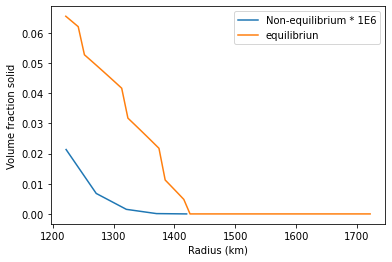

In [9]:
fig, ax = plt.subplots()
ax.plot(analysis_radii/1000.0, solid_vf*1.0E6, label='Non-equilibrium * 1E6')
ax.plot(rs/1000.0, feot.volume_fraction_solid(xs, ps, ts), label='equilibriun')
ax.set_ylabel('Volume fraction solid')
ax.set_xlabel('Radius (km)')
ax.legend()
plt.show()

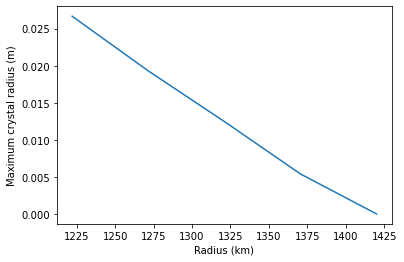

In [10]:
fig, ax = plt.subplots()
ax.plot(analysis_radii/1000.0, np.max(particle_radius_unnormalised, axis=1))
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Maximum crystal radius (m)')
plt.show()

## To do

What next? It seems we can proceed in three ways:

1. Find $\frac{\mathscr{N}}{\mathscr{F}}$ that gives 1 km/Myr (or whatever) for G. Evaluate the resulting seismic structure of the F-layer.
2. Use $\mathscr{N}$ (from previous work, and this can then depend on $z$). Assume $\mathscr{F}$ is 1 (or whatever) and compare with F-layer
3. Do a comparison between equilibrium and non-equilibrium case (as close as we can manage).

However, first we may want to think about remove the interaction radius thing all togher. Instead we can
just use the 'F-layer liquid composition' as the composition on the outside edge of the bounday layer,
let this be radius dependent, and update this in the self consistent loop. This ought to be fine 
but I'm not sure how we can illustrate a single particle case if we do that.

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


/Users/andrewwalker/miniforge3/envs/py38-arm/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


Liquidus temperature at top of F-layer is 5679.607605571524 K
Temperature CMB is 4228.150449232594 K


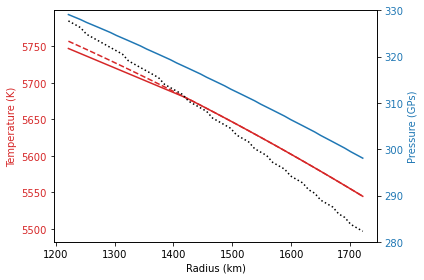

In [11]:
# This is where we set all the F-layer parameters. Quite slow (due to liquidus calc I think)

# F-layer setup
radius_inner_core = 1221.5e3
radius_top_flayer = radius_inner_core + 200.0e3 # 200 km thick.
radius_cmb = 3480.0e3 # We only need this for setup.
gamma = 1.5

# Check PREM works
print("Pressure at ICB:", prem.pressure(radius_inner_core/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(radius_top_flayer/1000.0), "GPa")
print("g at ICB:", prem.gravity(radius_inner_core/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(radius_top_flayer/1000.0), "m/s**2")

# Generate the functions for temperautre,
# composition, pressure and gravity
tfunc, atfunc, xfunc, pfunc, \
    gfunc = setup_flayer_functions(radius_inner_core, radius_cmb, radius_top_flayer, 
                                                    gamma, 10.0, 0.95, 0.95)

# Interpolate onto radius for plotting
rs = np.linspace(radius_inner_core, radius_inner_core+500.0E3)
ts = tfunc(rs)
ats = atfunc(rs)
ps = pfunc(rs)
xs = xfunc(rs)
# Find the P-X dependent liquidus (storing the temperature at each point)
tl = feot.find_liquidus(xs, ps)


# Plot the F-layer setup alongside the liquidus
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ts, color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, ps, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([280, 330])

fig.tight_layout()  
plt.show()

In [12]:
# IVP defaults
start_time = 0 # s
max_time = 100000000000 # s
rtot = 1.0 # initial interaction radius

# Physical properties
initial_particle_size = 1.0E-10 # initial radius, m - should be critical radius for nucleation
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

nucleation_radii = np.linspace(radius_inner_core+1000.0, radius_top_flayer-1000.0, 10)
analysis_radii = np.linspace(radius_inner_core+500.0, radius_top_flayer-1500.0, 5)
initial_seperations = np.ones_like(analysis_radii)*rtot
nucleation_rates = np.ones_like(nucleation_radii)*1.0E-14 # Same everywhere
maximum_seperation = 3.0 # Don't let this be too big - root finder in oxygen conservation in 
                         # region of interest not accurate enough.

solutions, particle_densities, calculated_interaction_radii, growth_rate, solid_vf, \
    particle_radius_unnormalised, particle_radius_histogram = solve_flayer(
    nucleation_radii, nucleation_rates, analysis_radii, initial_seperations, 
    maximum_seperation)

Starting ODE IVP solver for nuclation at 1222500.0
icb at t =  55245.28203176694 s, with particle radius =  0.0025126512242152755
did not dissolve
reached r =  1222000.0 m at t =  37904.937923170015 s, with particle radius =  0.0018697272214292808
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1244500.0
icb at t =  361007.29308018665 s, with particle radius =  0.011538872803671656
did not dissolve
reached r =  1222000.0 m at t =  356276.43525365484 s, with particle radius =  0.011389716647842725
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1266500.0
icb at t =  558013.0489538914 s, with particle radius =  0.015405099223598853
did not dissolve
reached r =  1222000.0 m at t =  553876.8802319906 s, with particle radius =  0.015297243781122625
did not re

Starting ODE IVP solver for nuclation at 1222500.0
icb at t =  55269.64674803961 s, with particle radius =  0.0025116792366972787
did not dissolve
reached r =  1222000.0 m at t =  37928.9181623199 s, with particle radius =  0.0018676006507726832
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1244500.0
icb at t =  362076.0100262812 s, with particle radius =  0.011428106180123401
did not dissolve
reached r =  1222000.0 m at t =  357248.35628501157 s, with particle radius =  0.01129016588264975
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1266500.0
icb at t =  559257.7069070045 s, with particle radius =  0.016157326751172436
did not dissolve
reached r =  1222000.0 m at t =  555267.9557042402 s, with particle radius =  0.016041864615259967
did not reach 

/Users/andrewwalker/miniforge3/envs/py38-arm/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


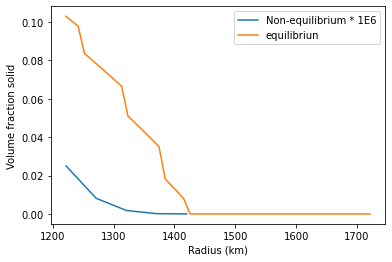

In [13]:
fig, ax = plt.subplots()
ax.plot(analysis_radii/1000.0, solid_vf*1.0E6, label='Non-equilibrium * 1E6')
ax.plot(rs/1000.0, feot.volume_fraction_solid(xs, ps, ts), label='equilibriun')
ax.set_ylabel('Volume fraction solid')
ax.set_xlabel('Radius (km)')
ax.legend()
plt.show()

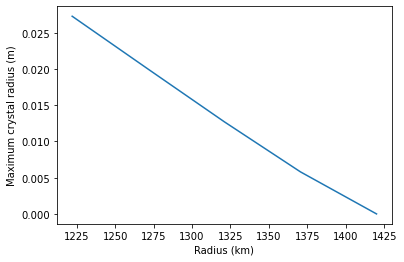

In [14]:
fig, ax = plt.subplots()
ax.plot(analysis_radii/1000.0, np.max(particle_radius_unnormalised, axis=1))
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Maximum crystal radius (m)')
plt.show()